In [1]:
%matplotlib inline

C:\Users\maddy\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\maddy\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\maddy\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\maddy\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Sensitivity Analysis Plots


## Helper Functions & Setting Variables

Create lists of the values tested for each variable - to be used in the plot x-axes

In [4]:
alphas = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0] 
betas = [0.01, 0.1, 0.25, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99] 
gammas = [0.01, 0.1, 0.25, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99] 
lamb = [0.01, 0.1, 0.25, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

n_neurons =  [10, 100, 500, 1000, 1500, 2000, 2500, 3000, 5000] 
sparsity = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

n_dims = [64, 128, 256, 532]  

Functions for extracting data needed for plotting

In [5]:
## function taken from seaborn for calculating confidence intervals
## https://github.com/mwaskom/seaborn/blob/master/seaborn/utils.py
def get_ci(a, which=95, axis=None):
    """Return a percentile range from an array of values."""
    p = 50 - which / 2, 50 + which / 2
    return np.nanpercentile(a, p, axis)

def get_mean_data(data_frame, test_var, var_list, goal, replace):    
    ## Define the 'goal' score 
    goal = goal
    ## Create list for storing the number of trials needed to reach the goal score and value of testing variable
    goal_reached = []
    confidence = []
    ## For each testing value ...
    for x in var_list:
        ## extract rows into new dataframe
        data = data_frame.loc[data_frame[test_var] == x]
        data = data.reset_index()
        
        #if the experiments couldn't be run, fill with nan
        if len(data) == 0:
            for i in range(5):
                goal_reached.append(np.nan)
        
        ## for each row grab the index of the first value in the rolling mean data which exceeds the goal
        for i in range(len(data)):
            ## GOAL FOR MINIGRID
            if goal < 1:
                a=[index for index,val in enumerate(data['roll_mean'][i][0]) if val > goal]
            ## GOAL FOR MOUNTAINCAR
            elif goal > 1:
                ## grab the index of the first value in the rolling mean data which exceeds the goal
                a=[index for index,val in enumerate(data['roll_mean'][i][0]) if np.abs(val) < goal]

            ## DEALING WITH MISSING VALUES
            ## Replace missing values with 10,000
            if replace:
                ## if experiment never reached goal, put max number of runs in list
                if len(a) < 1:
                    goal_reached.append(10000)
                ## otherwise, add the index to the list for plotting
                else:
                    goal_reached.append(a[0])
            ## Replace missing values with nan
            else:
                ## if experiment never reached goal, put nan in list
                if len(a) < 1:
                    goal_reached.append(np.nan)
                ## otherwise, add the index to the list for plotting
                else:
                    goal_reached.append(a[0])

    ## convert list to np array
    goal_reached = np.asarray(goal_reached)
    goal_reached = goal_reached.reshape(-1, 5)
    
    for i in range(len(goal_reached)):
        data = goal_reached[i]

        confidence.append(get_ci(data))
    
    ## reshape the array so that each row consists of the N repetitions where the same value was tested
    mean_runs = np.nanmean(goal_reached, axis=1)
    ## if the network never achieved success with that parameter value, replace value with nan so no data is plotted
    for i in range(len(mean_runs)):
        if mean_runs[i]==10000:
            mean_runs[i] = np.nan
    
    return mean_runs, confidence

## function taken from seaborn for converting confidence intervals to errors for errorbars
## https://github.com/mwaskom/seaborn/blob/master/seaborn/utils.py
def ci_to_errsize(cis, heights):
    """Convert intervals to error arguments relative to plot heights.
    Parameters
    ----------
    cis : 2 x n sequence
        sequence of confidence interval limits
    heights : n sequence
        sequence of plot heights
    Returns
    -------
    errsize : 2 x n array
        sequence of error size relative to height values in correct
        format as argument for plt.bar
    """
    cis = np.atleast_2d(cis).reshape(2, -1)
    heights = np.atleast_1d(heights)
    errsize = []
    for i, (low, high) in enumerate(np.transpose(cis)):
        h = heights[i]
        elow = h - low
        ehigh = high - h
        errsize.append([elow, ehigh])

    errsize = np.asarray(errsize).T
    return errsize

In [6]:
# Function for plotting the means and confidence intervals as error bars
def plot_data(data, var, values, x, goal, ax=None, replace = False, **kwargs):
    '''
    data = data frame for data to be plotted
    var = column name for the column in the dataframe reporting the values of the testing variable
    values = list containing the values that were tested
    '''
    #get means and confidence intervals
    means, ci = get_mean_data(data, var, values, goal, replace)
    #reshape confidence intervals to an array with shape [len, 2]
    ci = np.asarray(ci).reshape(len(values),2).T 
    #convert confidence intervals to error bars for plotting
    error = ci_to_errsize(ci, means)
    
    #convert xticks to strings for even spacing
    x_ticks = [str(i) for i in values]
    x_ticks = [str(i).lstrip('0') for i in values]
    
    #plot mean runs to reach goal
    #plot confidence intervals as errorbars
    
    if ax is None:
        ax = plt.gca()
        
    ax.errorbar(x_ticks, means, yerr=error, elinewidth=3, **kwargs)
    #highlight marker for the value used 
    ax.plot(x_ticks[x], means[x], markersize = (kwargs.get('markersize') + 5), color = kwargs.get('color'), 
             marker = kwargs.get('marker'), markeredgecolor='black')
    #show xticks
    ax.set_xticklabels(x_ticks, fontsize=18)
    ylabels = ax.get_yticklabels()
    ax.set_yticklabels(ylabels, fontsize=18)

In [7]:
# Function for finding the smallest mean in each dataframe
# returns the smallest mean and the index position
def find_best(data_frame, test_var, var_list, goal, replace):
    means, ci = get_mean_data(data_frame, test_var, var_list, goal, replace)
    minMean = np.nanmin(means)
    minPos = np.where(means == minMean)
    minPos = minPos[0][0].item()
    ci_LL = ci[minPos][0]
    ci_UL = ci[minPos][1]
    
    return(minMean, minPos, ci_LL, ci_UL)

# MiniGrid TD(0)

In [8]:
data_folder = Path('data/')

In [9]:
alpha_1H_nn = pd.read_pickle(data_folder/'alpha_MG1HNNTD0_data')
alpha_1H_n = pd.read_pickle(data_folder/'alpha_MG1HNTD0_data')
alpha_SSP_n = pd.read_pickle(data_folder/'alpha_MGSSPNTD0_data')
alpha_Grid_n = pd.read_pickle(data_folder/'alpha_MGGridSSPNTD0_data')

beta_1H_nn = pd.read_pickle(data_folder/'beta_MG1HNNTD0_data')
beta_1H_n = pd.read_pickle(data_folder/'beta_MG1HNTD0_data')
beta_SSP_n = pd.read_pickle(data_folder/'beta_MGSSPNTD0_data')
beta_Grid_n = pd.read_pickle(data_folder/'beta_MGGridSSPNTD0_data')

gamma_1H_nn = pd.read_pickle(data_folder/'gamma_MG1HNNTD0_data')
gamma_1H_n = pd.read_pickle(data_folder/'gamma_MG1HNTD0_data')
gamma_SSP_n = pd.read_pickle(data_folder/'gamma_MGSSPNTD0_data')
gamma_Grid_n = pd.read_pickle(data_folder/'gamma_MGGridSSPNTD0_data')

neurons_1H_n = pd.read_pickle(data_folder/'neurons_MG1HNTD0_data')
neurons_SSP_n = pd.read_pickle(data_folder/'neurons_MGSSPNTD0_data')
neurons_Grid_n = pd.read_pickle(data_folder/'neurons_MGGridSSPNTD0_data')

sparsity_1H_n = pd.read_pickle(data_folder/'sparsity_MG1HNTD0_data')
sparsity_SSP_n = pd.read_pickle(data_folder/'sparsity_MGSSPNTD0_data')
sparsity_Grid_n = pd.read_pickle(data_folder/'sparsity_MGGridSSPNTD0_data')

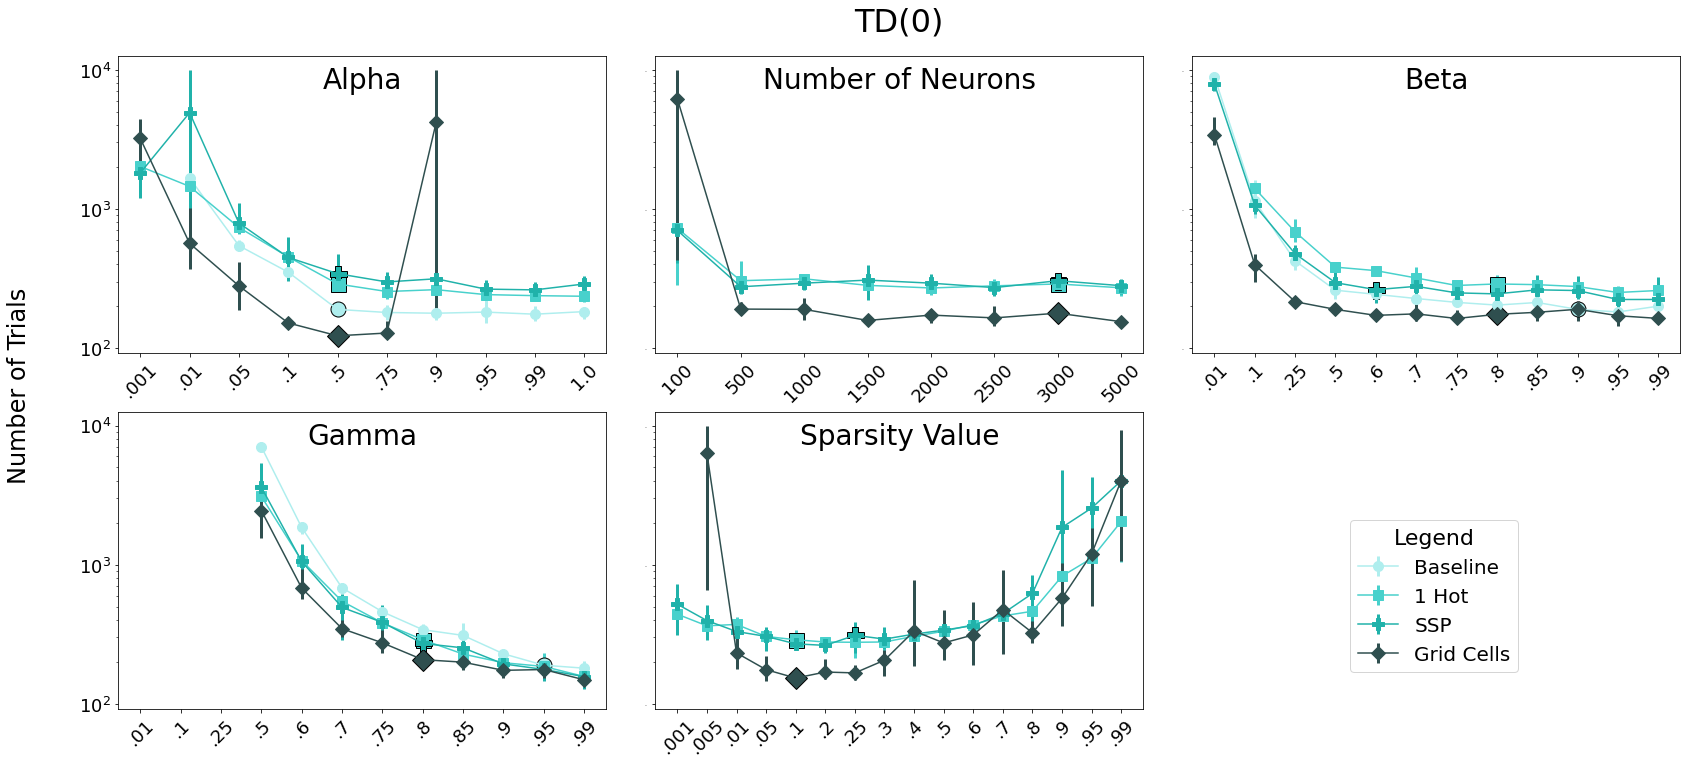

In [10]:
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(28)

fig.text(0.49, 0.91, "TD(0)", fontsize = 32)
fig.text(0.07, 0.5, 'Number of Trials', va='center', rotation='vertical', fontsize=24)


plt.subplots_adjust(wspace=0.1)

## ALPHA ##
ax1 = plt.subplot2grid(shape=(2, 3), loc=(0, 0), colspan=1)

plot_data(alpha_1H_nn, 'alpha', alphas, 5, goal = 0.95, ax=ax1, replace = True,
              marker = 'o', markersize = 10, label = 'Baseline', color = 'paleturquoise')
plot_data(alpha_1H_n, 'alpha', alphas, 5, goal = 0.95, ax=ax1, replace = True,
          marker = 's', markersize = 10, label = '1 Hot', color = 'mediumturquoise')
plot_data(alpha_SSP_n, 'alpha', alphas, 5, goal = 0.95, ax=ax1, replace = True,
          marker = 'P', markersize = 12, label = 'SSP', color = 'lightseagreen')
plot_data(alpha_Grid_n, 'alpha', alphas, 5, goal = 0.95, ax=ax1, replace = True,
          marker = 'D', markersize = 10, label = 'Grid Cells', color = 'darkslategrey')
ax1.set_title('Alpha', fontsize=28, y=1.0, pad=-32)
ax1.set_yscale('log')
ax1.tick_params(axis='x', labelrotation=45)

## NEURONS ##
ax2 = plt.subplot2grid(shape=(2, 3), loc=(0,1), colspan=1, sharey=ax1)

plot_data(neurons_1H_n, 'n_neurons', n_neurons, -2, goal = 0.95, ax=ax2, replace = True,
          marker = 's', markersize = 10, label = '1 Hot', color = 'mediumturquoise')
plot_data(neurons_SSP_n, 'n_neurons', n_neurons, -2, goal = 0.95, ax=ax2, replace = True,
          marker = 'P', markersize = 12, label = 'SSP', color = 'lightseagreen')
plot_data(neurons_Grid_n, 'n_neurons', n_neurons, -2, goal = 0.95, ax=ax2, replace = True,
          marker = 'D', markersize = 10, label = 'Grid Cells', color = 'darkslategrey')
ax2.set_title('Number of Neurons', fontsize=28, y=1.0, pad=-32)
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelsize=0)
ax2.tick_params(axis='x', labelrotation=45)

## BETA ##
ax4 = plt.subplot2grid(shape=(2, 3), loc=(0,2), colspan=1, sharey=ax1)

plot_data(beta_1H_nn, 'beta', betas, -3, goal = 0.95, ax=ax4, replace = True,
          marker = 'o', markersize = 10, label = 'Baseline', color = 'paleturquoise')
plot_data(beta_1H_n, 'beta', betas, -5, goal = 0.95, ax=ax4, replace = True,
          marker = 's', markersize = 10, label = '1 Hot', color = 'mediumturquoise')
plot_data(beta_SSP_n, 'beta', betas, 4, goal = 0.95, ax=ax4, replace = True,
          marker = 'P', markersize = 12, label = 'SSP', color = 'lightseagreen')
plot_data(beta_Grid_n, 'beta', betas, -5, goal = 0.95, ax=ax4, replace = True,
          marker = 'D', markersize = 10, label = 'Grid Cells', color = 'darkslategrey')
ax4.set_title('Beta', fontsize=28, y=1.0, pad=-32)
ax4.set_yscale('log')
ax4.tick_params(axis='y', labelsize=0)
ax4.tick_params(axis='x', labelrotation=45)

## GAMMA ##
ax5 = plt.subplot2grid(shape=(2, 3), loc=(1, 0), colspan=1, sharex=ax4, sharey=ax1)#, sharex=ax4)

plot_data(gamma_1H_nn, 'gamma', gammas, -2, goal = 0.95, ax=ax5, replace = True,
          marker = 'o', markersize = 10, label = 'Baseline', color = 'paleturquoise')
plot_data(gamma_1H_n, 'gamma', gammas, -5, goal = 0.95, ax=ax5, replace = True,
          marker = 's', markersize = 10, label = '1 Hot', color = 'mediumturquoise')
plot_data(gamma_SSP_n, 'gamma', gammas, 7, goal = 0.95, ax=ax5, replace = True,
          marker = 'P', markersize = 12, label = 'SSP', color = 'lightseagreen')
plot_data(gamma_Grid_n, 'gamma', gammas, -5, goal = 0.95, ax=ax5, replace = True,
          marker = 'D', markersize = 10, label = 'Grid Cells', color = 'darkslategrey')
ax5.set_title('Gamma', fontsize=28, y=1.0, pad=-32)
ax5.set_yscale('log')
ax5.tick_params(axis='x', labelrotation=45)

## SPARSITY ##
ax6 = plt.subplot2grid(shape=(2, 3), loc=(1, 1), colspan=1, sharey=ax1)

plot_data(sparsity_1H_n, 'sparsity', sparsity, 4, goal = 0.95, ax=ax6, replace = True,
          marker = 's', markersize = 10, label = '1 Hot', color = 'mediumturquoise')
plot_data(sparsity_SSP_n, 'sparsity', sparsity, 6, goal = 0.95, ax=ax6, replace = True,
          marker = 'P', markersize = 12, label = 'SSP', color = 'lightseagreen')
plot_data(sparsity_Grid_n, 'sparsity', sparsity, 4, goal = 0.95, ax=ax6, replace = True,
          marker = 'D', markersize = 10, label = 'Grid Cells', color = 'darkslategrey')
ax6.set_title('Sparsity Value', fontsize=28, y=1.0, pad=-32)
ax6.set_yscale('log')
ax6.tick_params(axis='y', labelsize=0)
ax6.tick_params(axis='x', labelrotation=45)

# Set Legend
lines, labels = ax1.get_legend_handles_labels()
fig.legend(lines, labels, loc = (0.8,0.12), fontsize=20, title='Legend',title_fontsize=22);

# Save as PDF
#fig.savefig('figures/minigrid_TD0.pdf', bbox_inches='tight');

### Find Best

In [11]:
# Create lists for for loop
DATAFRAMES = [alpha_1H_nn, alpha_1H_n, alpha_SSP_n, alpha_Grid_n,
             beta_1H_nn, beta_1H_n, beta_SSP_n, beta_Grid_n,
             gamma_1H_nn, gamma_1H_n, gamma_SSP_n, gamma_Grid_n, 
             neurons_1H_n, neurons_SSP_n, neurons_Grid_n, 
             sparsity_1H_n, sparsity_SSP_n, sparsity_Grid_n]
TEST_VARS = ['alpha', 'alpha', 'alpha', 'alpha',
            'beta', 'beta', 'beta', 'beta',
            'gamma', 'gamma', 'gamma', 'gamma',
            'n_neurons', 'n_neurons', 'n_neurons',
            'sparsity', 'sparsity', 'sparsity']
VAR_LISTS = [alphas, alphas, alphas, alphas,
            betas, betas, betas, betas,
            gammas, gammas, gammas, gammas,
            n_neurons, n_neurons, n_neurons,
            sparsity, sparsity, sparsity]

# Create list for saving the means
means_list = []
ci_LL_list = []
ci_UL_list = []

# Loop through each dataframe and create a new dataframe containing the 
# parameters for each best performing implementation
for i in range(len(DATAFRAMES)):
    data_frame = DATAFRAMES[i]
    test_var = TEST_VARS[i]
    var_list = VAR_LISTS[i]
    goal = 0.95
    replace = True
    
    minMean, minPos, ci_LL, ci_UL = find_best(data_frame, test_var, var_list, goal, replace)
    means_list.append(minMean)
    ci_LL_list.append(ci_LL)
    ci_UL_list.append(ci_UL)
    
    if i==0:
        df = pd.DataFrame(data_frame.iloc[minPos*5]).T
        df.reset_index()
        
    else: 
        df = df.append(data_frame.iloc[minPos*5], ignore_index=True)
        
# Add in a column with the mean number of runs
df['Means'] = means_list
# Add columns for confidence intervals
df['CI LL'] = ci_LL_list
df['CI UL'] = ci_UL_list
# Add in a column showing whether or not neurons were used
df['neurons_True'] = 'False'
df.loc[df['n_neurons'] > 0, 'neurons_True'] = 'True'

In [12]:
# Get the best performing parameter sets for each of the representations
df.groupby(['rep', 'neurons_True']).agg({'Means':'min'})

min_index_group = df.groupby(['rep', 'neurons_True'])['Means'].idxmin()
best_by_group = pd.DataFrame(df.iloc[min_index_group[0]]).T

best_by_group = best_by_group.append(df.iloc[min_index_group[1]], ignore_index=True)
best_by_group = best_by_group.append(df.iloc[min_index_group[2]], ignore_index=True)
best_by_group = best_by_group.append(df.iloc[min_index_group[3]], ignore_index=True)
best_by_group

,seed,env,rep,trials,steps,rule,n,alpha,beta,gamma,...,intercepts,sample_encoders,report_weights,dims,roll_mean,sparsity,Means,CI LL,CI UL,neurons_True
0,0,MiniGrid,GridSSP,10000,200,TD(0),None,0.5,0.85,0.95,...,NaN,False,False,None,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",0.1,122.2,115.3,132.9,True
1,0,MiniGrid,One Hot,10000,200,TD(0),None,0.99,0.9,0.95,...,NaN,False,False,None,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",NaN,174.8,156.0,201.3,False
2,0,MiniGrid,One Hot,10000,200,TD(0),None,0.5,0.8,0.99,...,NaN,False,False,None,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",0.1,157.0,149.3,163.0,True
3,0,MiniGrid,SSP,10000,200,TD(0),None,0.5,0.6,0.99,...,NaN,False,False,128,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",0.25,156.6,127.7,172.1,True


Quickly plot the rolling averages for the "best" runs

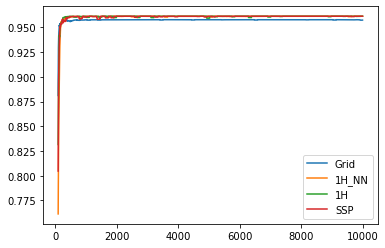

In [13]:
plt.plot(best_by_group['roll_mean'][0][0], label = 'Grid')
plt.plot(best_by_group['roll_mean'][1][0], label = '1H_NN')
plt.plot(best_by_group['roll_mean'][2][0], label = '1H')
plt.plot(best_by_group['roll_mean'][3][0], label = 'SSP')
plt.legend()

# MiniGrid TD($\lambda$)

In [14]:
alpha_1H_nn_lam = pd.read_pickle(data_folder/'alpha_MG1HNNTDLam_data')
alpha_1H_n_lam = pd.read_pickle(data_folder/'alpha_MG1HNTDLam_data')
alpha_SSP_n_lam = pd.read_pickle(data_folder/'alpha_MGSSPNTDLam_data')
alpha_Grid_n_lam = pd.read_pickle(data_folder/'alpha_MGGridSSPNTDLam_data')

beta_1H_nn_lam = pd.read_pickle(data_folder/'beta_MG1HNNTDLam_data')
beta_1H_n_lam = pd.read_pickle(data_folder/'beta_MG1HNTDLam_data')
beta_SSP_n_lam = pd.read_pickle(data_folder/'beta_MGSSPNTDLam_data')
beta_Grid_n_lam = pd.read_pickle(data_folder/'beta_MGGridSSPNTDLam_data')

gamma_1H_nn_lam = pd.read_pickle(data_folder/'gamma_MG1HNNTDLam_data')
gamma_1H_n_lam = pd.read_pickle(data_folder/'gamma_MG1HNTDLam_data')
gamma_SSP_n_lam = pd.read_pickle(data_folder/'gamma_MGSSPNTDLam_data')
gamma_Grid_n_lam = pd.read_pickle(data_folder/'gamma_MGGridSSPNTDLam_data')

lambda_1H_nn_lam = pd.read_pickle(data_folder/'lambda_MG1HNNTDLam_data')
lambda_1H_n_lam = pd.read_pickle(data_folder/'lambda_MG1HNTDLam_data')
lambda_SSP_n_lam = pd.read_pickle(data_folder/'lambda_MGSSPNTDLam_data')
lambda_Grid_n_lam = pd.read_pickle(data_folder/'lambda_MGGridSSPNTDLam_data')

neurons_1H_n_lam = pd.read_pickle(data_folder/'neurons_MG1HNTDLam_data')
neurons_SSP_n_lam = pd.read_pickle(data_folder/'neurons_MGSSPNTDLam_data')
neurons_Grid_n_lam = pd.read_pickle(data_folder/'neurons_MGGridSSPNTDLam_data')

sparsity_1H_n_lam = pd.read_pickle(data_folder/'sparsity_MG1HNTDLam_data')
sparsity_SSP_n_lam = pd.read_pickle(data_folder/'sparsity_MGSSPNTDLam_data')
sparsity_Grid_n_lam = pd.read_pickle(data_folder/'sparsity_MGGridSSPNTDLam_data')

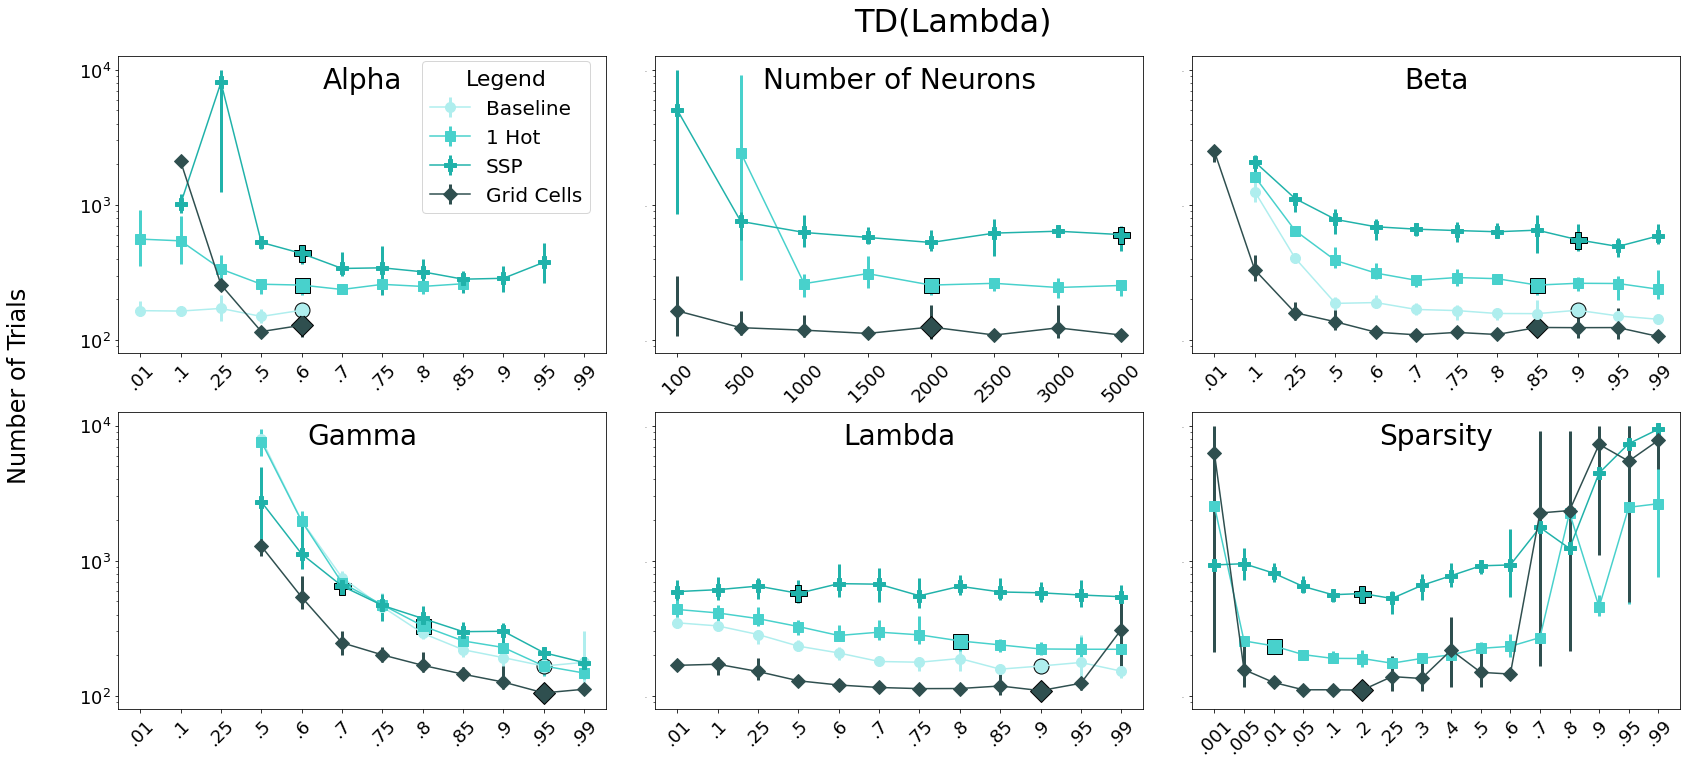

In [15]:
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(28)

fig.text(0.49, 0.91, "TD(Lambda)", fontsize = 32)
fig.text(0.07, 0.5, 'Number of Trials', va='center', rotation='vertical', fontsize=24)


plt.subplots_adjust(wspace=0.1)

## ALPHA ##
ax1 = plt.subplot2grid(shape=(2, 3), loc=(0, 0), colspan=1)

plot_data(alpha_1H_nn_lam, 'alpha', alphas, 4, goal = 0.95, ax=ax1, replace = True,
              marker = 'o', markersize = 10, label = 'Baseline', color = 'paleturquoise')
plot_data(alpha_1H_n_lam, 'alpha', alphas, 4, goal = 0.95, ax=ax1, replace = True,
          marker = 's', markersize = 10, label = '1 Hot', color = 'mediumturquoise')
plot_data(alpha_SSP_n_lam, 'alpha', alphas, 4, goal = 0.95, ax=ax1, replace = True,
          marker = 'P', markersize = 12, label = 'SSP', color = 'lightseagreen')
plot_data(alpha_Grid_n_lam, 'alpha', alphas, 4, goal = 0.95, ax=ax1, replace = True,
          marker = 'D', markersize = 10, label = 'Grid Cells', color = 'darkslategrey')
ax1.set_title('Alpha', fontsize=28, y=1.0, pad=-32)
ax1.set_yscale('log')
ax1.tick_params(axis='x', labelrotation=45)

## NEURONS ##
ax2 = plt.subplot2grid(shape=(2, 3), loc=(0, 1), colspan=1, sharey=ax1)

plot_data(neurons_1H_n_lam, 'n_neurons', n_neurons, -4, goal = 0.95, ax=ax2, replace = True,
          marker = 's', markersize = 10, label = '1 Hot', color = 'mediumturquoise')
plot_data(neurons_SSP_n_lam, 'n_neurons', n_neurons, -1, goal = 0.95, ax=ax2, replace = True,
          marker = 'P', markersize = 12, label = 'SSP', color = 'lightseagreen')
plot_data(neurons_Grid_n_lam, 'n_neurons', n_neurons, -4, goal = 0.95, ax=ax2, replace = True,
          marker = 'D', markersize = 10, label = 'Grid Cells', color = 'darkslategrey')
ax2.set_title('Number of Neurons', fontsize=28, y=1.0, pad=-32)
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelsize=0)
ax2.tick_params(axis='x', labelrotation=45)

## BETA ##
ax3 = plt.subplot2grid(shape=(2, 3), loc=(0, 2), colspan=1, sharey=ax1)

plot_data(beta_1H_nn_lam, 'beta', betas, -3, goal = 0.95, ax=ax3, replace = True,
          marker = 'o', markersize = 10, label = 'Baseline', color = 'paleturquoise')
plot_data(beta_1H_n_lam, 'beta', betas, -4, goal = 0.95, ax=ax3, replace = True,
          marker = 's', markersize = 10, label = '1 Hot', color = 'mediumturquoise')
plot_data(beta_SSP_n_lam, 'beta', betas, -3, goal = 0.95, ax=ax3, replace = True,
          marker = 'P', markersize = 12, label = 'SSP', color = 'lightseagreen')
plot_data(beta_Grid_n_lam, 'beta', betas, -4, goal = 0.95, ax=ax3, replace = True,
          marker = 'D', markersize = 10, label = 'Grid Cells', color = 'darkslategrey')
ax3.set_title('Beta', fontsize=28, y=1.0, pad=-32)
ax3.set_yscale('log')
ax3.tick_params(axis='y', labelsize=0)
ax3.tick_params(axis='x', labelrotation=45)


## GAMMA ##
ax4 = plt.subplot2grid(shape=(2, 3), loc=(1, 0), colspan=1, sharex=ax1, sharey=ax1)

plot_data(gamma_1H_nn_lam, 'gamma', gammas, -2, goal = 0.95, ax=ax4, replace = True,
          marker = 'o', markersize = 10, label = 'Baseline', color = 'paleturquoise')
plot_data(gamma_1H_n_lam, 'gamma', gammas, -5, goal = 0.95, ax=ax4, replace = True,
          marker = 's', markersize = 10, label = '1 Hot', color = 'mediumturquoise')
plot_data(gamma_SSP_n_lam, 'gamma', gammas, 5, goal = 0.95, ax=ax4, replace = True,
          marker = 'P', markersize = 12, label = 'SSP', color = 'lightseagreen')
plot_data(gamma_Grid_n_lam, 'gamma', gammas, -2, goal = 0.95, ax=ax4, replace = True,
          marker = 'D', markersize = 10, label = 'Grid Cells', color = 'darkslategrey')
ax4.set_title('Gamma', fontsize=28, y=1.0, pad=-32)
ax4.set_yscale('log')
ax4.tick_params(axis='x', labelrotation=45)

## LAMBDA ##
ax5 = plt.subplot2grid(shape=(2, 3), loc=(1, 1), colspan=1, sharey=ax1)

plot_data(lambda_1H_nn_lam, 'lambd', lamb, -3, goal = 0.95, ax=ax5, replace = True,
          marker = 'o', markersize = 10, label = 'Baseline', color = 'paleturquoise')
plot_data(lambda_1H_n_lam, 'lambd', lamb, -5, goal = 0.95, ax=ax5, replace = True,
          marker = 's', markersize = 10, label = '1 Hot', color = 'mediumturquoise')
plot_data(lambda_SSP_n_lam, 'lambd', lamb, 3, goal = 0.95, ax=ax5, replace = True,
          marker = 'P', markersize = 12, label = 'SSP', color = 'lightseagreen')
plot_data(lambda_Grid_n_lam, 'lambd', lamb, -3, goal = 0.95, ax=ax5, replace = True,
          marker = 'D', markersize = 10, label = 'Grid Cells', color = 'darkslategrey')
ax5.set_title('Lambda', fontsize=28, y=1.0, pad=-32)
ax5.set_yscale('log')
ax5.tick_params(axis='y', labelsize=0)
ax5.tick_params(axis='x', labelrotation=45)


## SPARSITY ##
ax6 = plt.subplot2grid(shape=(2, 3), loc=(1, 2), colspan=1, sharey=ax1)

plot_data(sparsity_1H_n_lam, 'sparsity', sparsity, 2, goal = 0.95, ax=ax6, replace = True,
          marker = 's', markersize = 10, label = '1 Hot', color = 'mediumturquoise')
plot_data(sparsity_SSP_n_lam, 'sparsity', sparsity, 5, goal = 0.95, ax=ax6, replace = True,
          marker = 'P', markersize = 12, label = 'SSP', color = 'lightseagreen')
plot_data(sparsity_Grid_n_lam, 'sparsity', sparsity, 5, goal = 0.95, ax=ax6, replace = True,
          marker = 'D', markersize = 10, label = 'Grid Cells', color = 'darkslategrey')
ax6.set_title('Sparsity', fontsize=28, y=1.0, pad=-32)
ax6.set_yscale('log')
ax6.tick_params(axis='y', labelsize=0)
ax6.tick_params(axis='x', labelrotation=45)

# Set Legend
lines, labels = ax1.get_legend_handles_labels()
fig.legend(lines, labels, loc = (0.25,0.72), fontsize=20, title='Legend',title_fontsize=22)

# Save as PDF
#fig.savefig('figures/minigrid_TDLambda.pdf', bbox_inches='tight')

### Find Best

In [16]:
# Create lists for for loop
DATAFRAMES = [alpha_1H_nn_lam, alpha_1H_n_lam, alpha_SSP_n_lam, alpha_Grid_n_lam,
             beta_1H_nn_lam, beta_1H_n_lam, beta_SSP_n_lam, beta_Grid_n_lam,
             gamma_1H_nn_lam, gamma_1H_n_lam, gamma_SSP_n_lam, gamma_Grid_n_lam, 
             lambda_1H_nn_lam, lambda_1H_n_lam, lambda_SSP_n_lam, lambda_Grid_n_lam,
             neurons_1H_n_lam, neurons_SSP_n_lam, neurons_Grid_n_lam, 
             sparsity_1H_n_lam, sparsity_SSP_n_lam, sparsity_Grid_n_lam]
TEST_VARS = ['alpha', 'alpha', 'alpha', 'alpha',
            'beta', 'beta', 'beta', 'beta',
            'gamma', 'gamma', 'gamma', 'gamma',
            'lambd', 'lambd', 'lambd', 'lambd',
            'n_neurons', 'n_neurons', 'n_neurons',
            'sparsity', 'sparsity', 'sparsity']
VAR_LISTS = [alphas, alphas, alphas, alphas,
            betas, betas, betas, betas,
            gammas, gammas, gammas, gammas,
            lamb, lamb, lamb, lamb,
            n_neurons, n_neurons, n_neurons,
            sparsity, sparsity, sparsity]

# Create list for saving the means
means_list = []
ci_LL_list = []
ci_UL_list = []

# Loop through each dataframe and create a new dataframe containing the 
# parameters for each best performing implementation
for i in range(len(DATAFRAMES)):
    data_frame = DATAFRAMES[i]
    test_var = TEST_VARS[i]
    var_list = VAR_LISTS[i]
    goal = 0.95
    replace = True
    
    minMean, minPos, ci_LL, ci_UL = find_best(data_frame, test_var, var_list, goal, replace)
    means_list.append(minMean)
    ci_LL_list.append(ci_LL)
    ci_UL_list.append(ci_UL)
    
    if i==0:
        df = pd.DataFrame(data_frame.iloc[minPos*5]).T
        df.reset_index()
        
    else: 
        df = df.append(data_frame.iloc[minPos*5], ignore_index=True)
        
# Add in a column with the mean number of runs
df['Means'] = means_list
# Add columns for confidence intervals
df['CI LL'] = ci_LL_list
df['CI UL'] = ci_UL_list
# Add in a column showing whether or not neurons were used
df['neurons_True'] = 'False'
df.loc[df['n_neurons'] > 0, 'neurons_True'] = 'True'

In [17]:
# Get the best performing parameter sets for each of the representations
df.groupby(['rep', 'neurons_True']).agg({'Means':'min'})

min_index_group = df.groupby(['rep', 'neurons_True'])['Means'].idxmin()
best_by_group = pd.DataFrame(df.iloc[min_index_group[0]]).T

best_by_group = best_by_group.append(df.iloc[min_index_group[1]], ignore_index=True)
best_by_group = best_by_group.append(df.iloc[min_index_group[2]], ignore_index=True)
best_by_group = best_by_group.append(df.iloc[min_index_group[3]], ignore_index=True)
best_by_group

,seed,env,rep,trials,steps,rule,n,alpha,beta,gamma,...,n_neurons,sparsity,sample_encoders,report_weights,dims,roll_mean,Means,CI LL,CI UL,neurons_True
0,0,MiniGrid,GridSSP,10000,200,TD(Lambda),None,0.1,0.85,0.95,...,2000,0.2,False,False,None,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",105.4,102.1,109.8,True
1,0,MiniGrid,One Hot,10000,200,TD(Lambda),None,0.1,0.99,0.95,...,None,None,False,False,None,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",142.8,135.5,154.7,False
2,0,MiniGrid,One Hot,10000,200,TD(Lambda),None,0.1,0.85,0.99,...,2000,0.005,False,False,None,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",147.8,133.5,164.9,True
3,0,MiniGrid,SSP,10000,200,TD(Lambda),None,0.1,0.9,0.99,...,5000,0.2,False,False,256,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",176.6,162.8,189.1,True


Quickly plot the rolling averages for the "best" runs

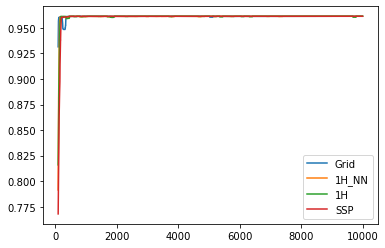

In [18]:
plt.plot(best_by_group['roll_mean'][0][0], label = 'Grid')
plt.plot(best_by_group['roll_mean'][1][0], label = '1H_NN')
plt.plot(best_by_group['roll_mean'][2][0], label = '1H')
plt.plot(best_by_group['roll_mean'][3][0], label = 'SSP')
plt.legend()